## Imports 

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras (for dataset)
import tensorflow as tf
from keras.datasets import mnist

# Scikit-learn (for validation split)
from sklearn.model_selection import train_test_split


## Load and Preprocess MNIST Data


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_test.shape)


(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Sample MNIST Digits

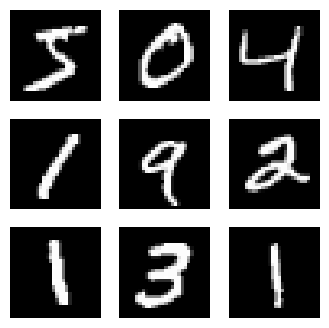

In [3]:

plt.figure(figsize=(4,4))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Validation Set

In [4]:

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(54000, 28, 28, 1) (6000, 28, 28, 1) (54000,) (6000,)


## CNN


In [5]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(28, 28, 1)),  # input explicitly defined here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9201 - loss: 0.2642 - val_accuracy: 0.9798 - val_loss: 0.0699
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9741 - loss: 0.0827 - val_accuracy: 0.9850 - val_loss: 0.0514
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9803 - loss: 0.0639 - val_accuracy: 0.9863 - val_loss: 0.0486
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9839 - loss: 0.0523 - val_accuracy: 0.9895 - val_loss: 0.0395
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9864 - loss: 0.0431 - val_accuracy: 0.9887 - val_loss: 0.0377
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9869 - loss: 0.0395 - val_accuracy: 0.9910 - val_loss: 0.0322
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9890 - loss: 0.0339 - val_accuracy: 0.9907 - val_loss: 0.0333
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9904 - loss: 0.0301 - val_accu

### Saving the model for future use

In [6]:
model.save('mnist_cnn_model.keras')


### Training Curves and Validation Curves

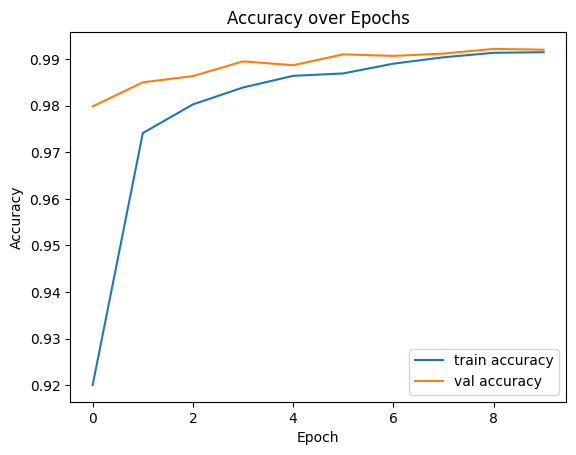

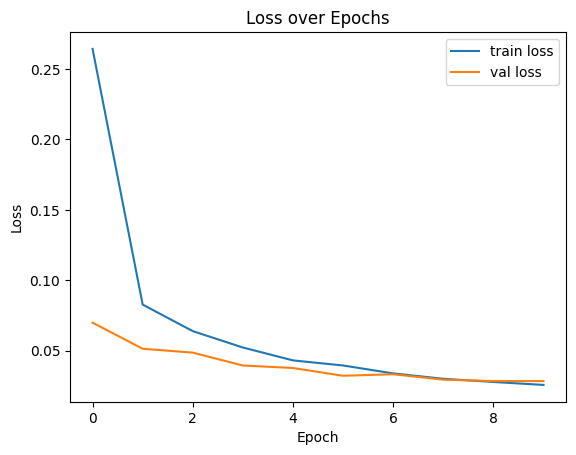

In [7]:
# Accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


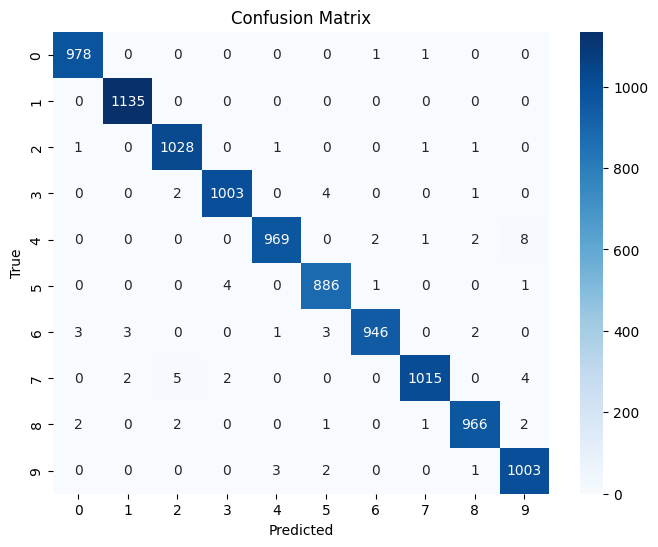

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=1)  # if using softmax output

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction pipeline

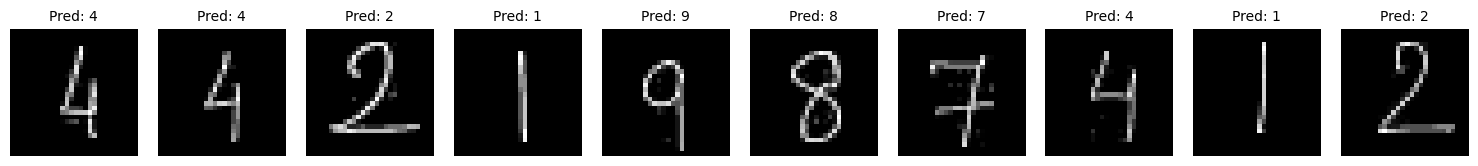

In [ ]:
import cv2
from keras.models import load_model

# Load trained model (same as used during training)
model = load_model("mnist_cnn_model.keras")

# Preprocessing helper: dilation, resize, pad, center, normalize
def preprocess_digit(roi):
    # Thicken thin strokes selectively
    if roi.shape[1] < 15:
        roi = cv2.dilate(roi, np.ones((2, 2), np.uint8), iterations=1)

    # Resize to fit in a 20x20 box while keeping aspect ratio
    h, w = roi.shape
    if h > w:
        new_h = 20
        new_w = max(1, int(w * (20 / h)))
    else:
        new_w = 20
        new_h = max(1, int(h * (20 / w)))
    digit = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to 28x28 and center
    pad_top = (28 - new_h) // 2
    pad_bottom = 28 - new_h - pad_top
    pad_left = (28 - new_w) // 2
    pad_right = 28 - new_w - pad_left
    digit = cv2.copyMakeBorder(digit, pad_top, pad_bottom, pad_left, pad_right,
                               borderType=cv2.BORDER_CONSTANT, value=0)

    # Center by center-of-mass (numpy only)
    ys, xs = np.nonzero(digit)
    if len(xs) and len(ys):
        cx = int(np.mean(xs))
        cy = int(np.mean(ys))
        shift_x = int(14 - cx)
        shift_y = int(14 - cy)
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        digit = cv2.warpAffine(digit, M, (28, 28), borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # Final normalization and shape
    digit = digit.astype("float32") / 255.0
    digit = np.expand_dims(digit, axis=-1)   # (28,28,1)
    digit = np.expand_dims(digit, axis=0)    # (1,28,28,1)
    return digit

# Single function: take user image path -> predicted string
def predict_sequence_from_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding for robust binarization (white digits on black)
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   blockSize=11, C=3)

    # Find external contours -> bounding boxes -> sort left-to-right
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = sorted(boxes, key=lambda b: b[0])

    predicted_digits = []
    preprocessed_tiles = []

    for (x, y, w, h) in boxes:
        if w < 5 or h < 5:
            continue  # skip tiny noise
        roi = thresh[y:y+h, x:x+w]
        digit_input = preprocess_digit(roi)           # (1,28,28,1)
        pred = model.predict(digit_input, verbose=0)
        predicted_digits.append(str(int(np.argmax(pred))))
        preprocessed_tiles.append(digit_input.squeeze())
        

    # --- Display all predicted digits horizontally with labels ---
    plt.figure(figsize=(15, 3))
    for i, digit_img in enumerate(preprocessed_tiles):
        plt.subplot(1, len(preprocessed_tiles), i + 1)
        plt.imshow(digit_img, cmap="gray")
        plt.title(f"Pred: {predicted_digits[i]}", fontsize=10)
        plt.axis("off")

    plt.tight_layout(pad=1.5)
    plt.show()


# --- Run on the user image ---
predicted_number = predict_sequence_from_image("multi_digit2.jpeg")


## Project Summary

This project demonstrates a complete handwritten digit recognition pipeline using a Convolutional Neural Network (CNN) trained on the MNIST dataset. It handles real-world images of handwritten digit sequences – including images written with mouse, touch input, or pen on paper – and successfully segments and classifies each digit.

### What was achieved:
- CNN models trained with high accuracy on MNIST
- Developed a custom image preprocessing pipeline:
  - Adaptive thresholding for robust binarization
  - Contour detection and bounding box sorting for point segmentation
  - Padding, resizing and centering to match MNIST input formatting
- Visual debugging included with bounding boxes and predicted labels
- Reached near-perfect prediction accuracy on multi-digit handwritten inputs, including user-generated samples

### Known Limitations:
- The model struggles with digits that deviate significantly from the MNIST style, especially "1" with a base or tilted orientation.
- Segmentation involves non-overlapping points and clean contours; Congested or touching points cannot be separated cleanly
- CNN was trained only on MNIST - no fine tuning on real-world handwriting styles
- Predictions work best when the points are evenly spaced and written clearly

